In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import statistics

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

df_covid19_cases_time= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv")

ukraine_progress = df_covid19_cases_time[df_covid19_cases_time['Country_Region'] == 'Ukraine'].copy().drop(['FIPS','UID','iso3', 'Report_Date_String', 'People_Tested', 'People_Hospitalized', 'Province_State', 'Recovered', 'Active', 'Delta_Recovered'],axis =1)
ukraine_progress.index = ukraine_progress['Country_Region']
ukraine_progress = ukraine_progress.drop(['Country_Region'], axis=1)

# periods dynamically calculated
dates = pd.date_range(datetime.today() - timedelta(days=1), end="1/22/20", periods=15).format(formatter=lambda x: x.strftime('%#m/%#d/%y'))

uk_data_to_display = ukraine_progress[ukraine_progress['Last_Update'].isin(dates)]


In [2]:
# Displaying confirmed cases in Ukraine 

df_uk = pd.DataFrame({'Last_Update':uk_data_to_display["Last_Update"],'Confirmed':uk_data_to_display["Confirmed"]})
df_uk.iplot(kind='bar',x='Last_Update',y='Confirmed')

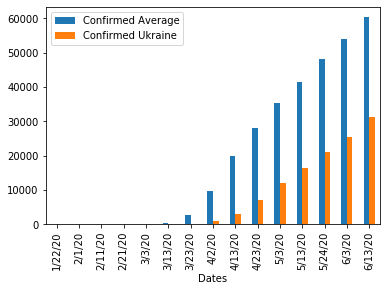

In [3]:
# Displaying histograms of Number of Average Confirmed cases and Ukraine confirmed cases

medical_rating = pd.read_csv("data/medical_system.csv")

top_50_medical_countries =  medical_rating.copy().drop(['Health Distribution','Overall goal attainment', 'Health expenditure per capita in international dollars', 'On level of health', 'Overall health system performance'],axis =1)

top_50_medical_countries.index = top_50_medical_countries["Country"]

top_50_medical_countries = top_50_medical_countries.drop(['Country'], axis=1).sort_values('Health Level').head(50)

all_countries_cases = df_covid19_cases_time.copy().drop(['FIPS','UID','iso3', 'Report_Date_String', 'People_Tested', 'People_Hospitalized', 'Province_State', 'Recovered', 'Active', 'Delta_Recovered'],axis =1)
all_countries_cases.index = all_countries_cases['Country_Region']
all_countries_cases = all_countries_cases.drop(['Country_Region'], axis=1)

top_50_medical_countries = pd.merge(top_50_medical_countries, all_countries_cases, left_index=True, right_index=True)

average_confirmed_data=[]

for indx, date in enumerate(dates):
    date_slice = top_50_medical_countries[top_50_medical_countries["Last_Update"] == date]["Confirmed"]
    average = sum(date_slice) / len(date_slice)
    average_confirmed_data.append(round(average))

average_confirmed_data = average_confirmed_data[::-1]

uk_average_data_to_display = uk_data_to_display.copy().drop(['Deaths', 'Incident_Rate', 'Last_Update', 'Delta_Confirmed'], axis=1)

df1 = pd.DataFrame(average_confirmed_data, columns=['Confirmed'])
df2 = pd.DataFrame(uk_average_data_to_display, columns=['Confirmed'])

df1['Dates'] = dates[::-1]
df2['Dates'] = dates[::-1]

mergedStuff = pd.merge(df1, df2, on=['Dates'], how='inner').rename(columns={"Confirmed_x": "Confirmed Average", "Confirmed_y": "Confirmed Ukraine"})

mergedStuff.head(20).plot(kind='bar', x='Dates')



In [22]:
# here we will compare confirmed-deaths cases in Ukraine and those countries close to it
# since the day one the Ukraine gorvernment was doing all to prevent registering ACTUAL deaths data
# here we will find out the ACTUAL NUMBER of the Death cases

# Note: countries should be close geographically to avoid varius coefficients
def get_countries_with_falsificated_data(close_countries):
    yesterdays_date = (datetime.today() - timedelta(days=1)).strftime('%#m/%#d/%y') 
    close_countries_data = df_covid19_cases_time[df_covid19_cases_time["Country_Region"].isin(close_countries)]
    close_countries_data = close_countries_data[close_countries_data["Last_Update"] == yesterdays_date].copy().drop(['Last_Update', 'Recovered', 'Active', 'Delta_Confirmed', 'Delta_Recovered', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Province_State', 'FIPS', 'UID', 'iso3', 'Report_Date_String'], axis=1)
    close_countries_data.index = close_countries_data["Country_Region"]
    close_countries_data = close_countries_data.drop(['Country_Region'], axis=1)

    medical_rating = pd.read_csv("data/medical_system.csv")
    medical_rating = medical_rating.copy().drop(['Health Distribution','Overall goal attainment', 'Health expenditure per capita in international dollars'],axis =1)
    medical_rating.index = medical_rating["Country"]
    medical_rating = medical_rating.drop(['Country'], axis=1)
    medical_rating = medical_rating.sort_values('Health Level')

    merged_data = pd.merge(close_countries_data, medical_rating, left_index=True, right_index=True)

    merged_data["coef"] = merged_data["Deaths"] /  ( merged_data["Confirmed"] * merged_data["Health Level"] )
    top_2_countries_by_health_level = merged_data.sort_values("Health Level").head(2)

    average_coef_by_most_healthy_counties = sum(top_2_countries_by_health_level["coef"]) / len(top_2_countries_by_health_level["coef"]) 
    max_coef = max(merged_data["coef"])
    min_coef = min(merged_data["coef"])

    merged_data["Most likely deaths"] = average_coef_by_most_healthy_counties * merged_data["Confirmed"] * merged_data["Health Level"]
    merged_data["Falsification %"] = (1 - merged_data["Deaths"] / merged_data["Most likely deaths"]) * 100
    merged_data["Max deaths (Worst-case scenario)"] = max_coef * merged_data["Confirmed"] * merged_data["Health Level"]
    merged_data["Worst-case scenario falsification %"] = (1 - merged_data["Deaths"] / merged_data["Max deaths (Worst-case scenario)"]) * 100
    
    merged_display_data = merged_data.rename(columns={"Deaths": "Official Deaths"}).drop(["Confirmed", "Health Level", "On level of health", "Overall health system performance", "coef"], axis=1)
    merged_display_data = merged_display_data[merged_data["Falsification %"] > 0]
    return merged_display_data

In [23]:
countries_with_falsification = get_countries_with_falsificated_data(["Poland", "Romania", "Ukraine", "Belarus"])

countries_with_falsification.style\
                        .background_gradient(cmap='YlOrBr',subset=["Official Deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["Most likely deaths"])\
                        .background_gradient(cmap='YlOrRd',subset=["Falsification %"])\
                        .background_gradient(cmap='YlOrRd',subset=["Max deaths (Worst-case scenario)"])\
                        .background_gradient(cmap='YlOrRd',subset=["Worst-case scenario falsification %"])\
                        .format("{:.2f}")

,Official Deaths,Most likely deaths,Falsification %,Max deaths (Worst-case scenario),Worst-case scenario falsification %
Belarus,303.00,2994.20,89.88,4186.29,92.76
Ukraine,890.00,1478.73,39.81,2067.46,56.95


In [24]:
countries_with_falsification = get_countries_with_falsificated_data(["Qatar", "Saudi Arabia", "Iran", "Pakistan"])

countries_with_falsification.style\
                        .background_gradient(cmap='YlOrBr',subset=["Official Deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["Most likely deaths"])\
                        .background_gradient(cmap='YlOrRd',subset=["Falsification %"])\
                        .background_gradient(cmap='YlOrRd',subset=["Max deaths (Worst-case scenario)"])\
                        .background_gradient(cmap='YlOrRd',subset=["Worst-case scenario falsification %"])\
                        .format("{:.2f}")

,Official Deaths,Most likely deaths,Falsification %,Max deaths (Worst-case scenario),Worst-case scenario falsification %
Qatar,70.00,372.22,81.19,2544.64,97.25
